In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Gemma2-9b-It")

In [4]:
llm.invoke("What is the capital of France?").content

'The capital of France is **Paris**. 🇫🇷  \n'

In [5]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.graph.message import add_messages
from typing import Annotated,Literal,TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [6]:
def call_model(state: MessagesState):
    messages=state['messages']
    response=llm.invoke(messages)
    return {"messages": [response]}

In [7]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
# workflow.add_node("tool", ToolNode(tools=[]))  # Provide an empty list or the required tools
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

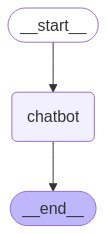

In [8]:
app

In [9]:
input={"messages":["Generate code in python for the following function:","def add(a:int,b:int)->int:"]}
res=app.invoke(input)


In [10]:
res

{'messages': [HumanMessage(content='Generate code in python for the following function:', additional_kwargs={}, response_metadata={}, id='ee35cbcf-860e-4ac2-9845-f124bf77ac33'),
  HumanMessage(content='def add(a:int,b:int)->int:', additional_kwargs={}, response_metadata={}, id='3390ff4b-ebc6-4272-a2d1-cba18b22c2e0'),
  AIMessage(content='```python\ndef add(a: int, b: int) -> int:\n  """\n  This function adds two integers.\n\n  Args:\n    a: The first integer.\n    b: The second integer.\n\n  Returns:\n    The sum of a and b.\n  """\n  return a + b\n``` \n\n**Explanation:**\n\n* **`def add(a: int, b: int) -> int:`**\n    * This line defines the function named `add`.\n    * `a: int` and `b: int` specify that the function expects two arguments, `a` and `b`, both of which should be integers.\n    * `-> int` indicates that the function will return an integer value.\n* **`"""..."""`**:\n    * This is a docstring, which provides a description of what the function does. It\'s good practice to 

In [11]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("________")
        print(value)
        print("\n")

Output from chatbot Node
________
{'messages': [AIMessage(content='```python\ndef add(a: int, b: int) -> int:\n  """Adds two integers together.\n\n  Args:\n    a: The first integer.\n    b: The second integer.\n\n  Returns:\n    The sum of the two integers.\n  """\n  return a + b\n```\n\n**Explanation:**\n\n* **`def add(a: int, b: int) -> int:`** This line defines the function named `add` that takes two arguments, `a` and `b`, both of type `int` (integer). The `-> int` part specifies that the function will return a value of type `int`.\n* **`"""Adds two integers together..."""`**: This is a docstring that describes what the function does. Docstrings are used to document code and can be accessed using the `help()` function or by hovering over the function name in an IDE.\n* **`return a + b`**: This line calculates the sum of `a` and `b` and returns the result.\n\n**How to use the function:**\n\n```python\nresult = add(5, 3)  # Call the function with arguments 5 and 3\nprint(result)     

In [45]:
@tool 
def search(query: str) -> str:
    """
    This a custom tool that searches for the given query.
    only use this tool if required.
    """
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "it's 60 degrees and foggy in San Francisco"
    return "It's 90 degrees and sunny in San Francisco"

In [46]:
search.invoke("What is the weather in San Francisco?")

"it's 60 degrees and foggy in San Francisco"

In [47]:
search.invoke("What is the weather in India?")

"It's 90 degrees and sunny in San Francisco"

In [48]:
tools=[search]

In [49]:
tool_node=ToolNode(tools=tools)

In [50]:
llm_with_tool=llm.bind_tools(tools=tools)

In [51]:
def call_model(state: MessagesState):
    messages=state['messages']
    response=llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [52]:
response=call_model({"messages":["Hi, How are you?"]})

In [1]:
response["messages"]

NameError: name 'response' is not defined

In [54]:
# messages=response['messages']
# messages[-1].tool_calls

In [55]:
def router_function(state : MessagesState)-> Literal["tools",END]:
    print(f"here is a state from should continue: {state}")
    messgaes=state['messages']
    last_message=messgaes[-1]
    print(f"here is a last message from should continue: {last_message}")
    if last_message.tool_calls:
        return "tools"
    else:
        return END

In [56]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent",call_model)
workflow.add_node("tools",tool_node)
workflow.add_edge(START,"agent")

workflow.add_conditional_edges("agent",
                               router_function,
                               {
                                    "tools": "tools",
                                    END: END
                               })
workflow.add_edge("tools", "agent")

app= workflow.compile()

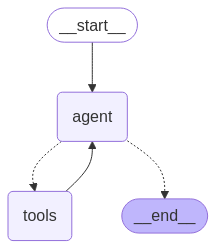

In [57]:
app

In [58]:
app.invoke({"messages":["Hi, How are you?"]})

here is a state from should continue: {'messages': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}, id='72e9af4c-e24f-467d-955c-53d1a7705510'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n4xr', 'function': {'arguments': '{"query":"How are you?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 955, 'total_tokens': 1037, 'completion_time': 0.149090909, 'prompt_time': 0.041258466, 'queue_time': 0.23373408299999998, 'total_time': 0.190349375}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb15b624-22af-44f0-875c-1726e82caac0-0', tool_calls=[{'name': 'search', 'args': {'query': 'How are you?'}, 'id': 'call_n4xr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 955, 'output_tokens': 82, 'total_tokens': 1037})]}
here is a last message from should continue: content='' addit

{'messages': [HumanMessage(content='Hi, How are you?', additional_kwargs={}, response_metadata={}, id='72e9af4c-e24f-467d-955c-53d1a7705510'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n4xr', 'function': {'arguments': '{"query":"How are you?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 955, 'total_tokens': 1037, 'completion_time': 0.149090909, 'prompt_time': 0.041258466, 'queue_time': 0.23373408299999998, 'total_time': 0.190349375}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb15b624-22af-44f0-875c-1726e82caac0-0', tool_calls=[{'name': 'search', 'args': {'query': 'How are you?'}, 'id': 'call_n4xr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 955, 'output_tokens': 82, 'total_tokens': 1037}),
  ToolMessage(content="It's 90 degrees and sunny in San Francisco", name='search', id='c9de136a-e3

In [59]:
for output in app.stream({"messages":["What is the weather in San Francisco?"]}):
    for key,value in output.items():
        print(f"Output from {key} ")
        print("________")
        print(value)
        print("\n")

here is a state from should continue: {'messages': [HumanMessage(content='What is the weather in San Francisco?', additional_kwargs={}, response_metadata={}, id='a1086d2b-3222-4a87-bd11-5358fba17358'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_phvc', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 957, 'total_tokens': 1040, 'completion_time': 0.150909091, 'prompt_time': 0.060137033, 'queue_time': 0.255875108, 'total_time': 0.211046124}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94b91be5-8593-4680-b146-5b9f5b6afc95-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_phvc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 957, 'output_tokens': 83, 'total_tokens': 1040})]}
here is a last message f

In [60]:
from langgraph.checkpoint.memory import MemorySaver

memory =MemorySaver()

In [76]:
workflow3 = StateGraph(MessagesState)
workflow3.add_node("agent",call_model)
workflow3.add_node("tools",tool_node)
workflow3.add_edge(START,"agent")

workflow3.add_conditional_edges("agent",
                               router_function,
                               {
                                    "tools": "tools",
                                    END: END
                               })
workflow3.add_edge("tools", "agent")



In [77]:
app3= workflow3.compile(checkpointer=memory)

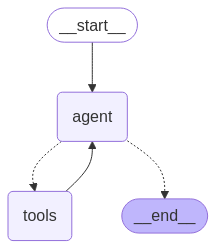

In [78]:
app3

In [79]:
config={"configuration":{"thread_id":"1"}}

In [87]:

# Ensure the configuration is correctly structured
config = {"thread_id": "1"}
events = app3.invoke({"messages": ["Then What is the weather of my city "]}, config, stream_mode="values")

here is a state from should continue: {'messages': [HumanMessage(content="How i's feels like  in the Bhavnagar", additional_kwargs={}, response_metadata={}, id='26c7a089-1c04-4c08-a277-decfa8d96252'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8wfe', 'function': {'arguments': '{"query":"current weather in Bhavnagar"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 961, 'total_tokens': 1046, 'completion_time': 0.154545455, 'prompt_time': 0.034125223, 'queue_time': 0.232402776, 'total_time': 0.188670678}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-50ce1741-89a7-432f-b26b-da6456c7de81-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in Bhavnagar'}, 'id': 'call_8wfe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 961, 'output_tokens': 85, 'total_tokens': 1046}), ToolMessage(conten

In [88]:
for event in events['messages']:
    event.pretty_print()
    

================================ Human Message =================================

How i's feels like  in the Bhavnagar
================================== Ai Message ==================================
Tool Calls:
  search (call_8wfe)
 Call ID: call_8wfe
  Args:
    query: current weather in Bhavnagar
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny in San Francisco
================================== Ai Message ==================================
Tool Calls:
  search (call_2g8x)
 Call ID: call_2g8x
  Args:
    query: current weather in Bhavnagar
================================= Tool Message =================================
Name: search

It's 90 degrees and sunny in San Francisco
================================== Ai Message ==================================

It looks like the tool is providing the weather for San Francisco.  Can you try calling the tool again with "Bhavnagar" in the query?
=========================